## **Predicting Suspect & Officer Behaviors of Officer-Involved Phoenix Shootings (OIS) Using Police Data**


### **Load Data & Libraries**

In [ ]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytube

In [ ]:
!pip install youtube-transcript-api


In [ ]:
!pip install -q yt-dlp youtube-transcript-api


In [ ]:
# pip install yt-dlp
# !yt-dlp -o "%(id)s.%(ext)s" <youtube_url>
# !pip install youtube-transcript-api
# pip install yt-dlp git+https://github.com/openai/whisper.git pandas
# !apt-get update && apt-get install -y ffmpeg
# !ffmpeg -version
# pip install --upgrade yt-dlp google-api-python-client


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import re
import subprocess

from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound
import time
import random
from youtube_transcript_api._errors import YouTubeRequestFailed

import os
import shutil

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
# load csvs using pandas
incident_details = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/ois-incident-details-2017-forward.csv', encoding='latin-1')
video_releases = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/ois-videos-and-media-releases-2019-forward.csv', encoding='latin-1')

# standardize the column
video_releases = video_releases.rename(columns={'INC RPT': 'INC_RPT'})

# drop duplicates based on INC_RPT, keeping only the first row
incident_details_unique = incident_details.sort_values('INC_RPT').drop_duplicates(subset='INC_RPT', keep='first')

merged_incidents = pd.merge(incident_details_unique, video_releases, on='INC_RPT', how='inner')

merged_incidents['DATE_x'] = pd.to_datetime(merged_incidents['DATE_x'], errors='coerce')  # from incident details
merged_incidents['DATE_y'] = pd.to_datetime(merged_incidents['DATE_y'], errors='coerce')  # from video releases (may have time)


# date matching
date_match_mask = merged_incidents['DATE_x'].dt.date == merged_incidents['DATE_y'].dt.date

mismatch_count = (~date_match_mask).sum()
print(f"Removing {mismatch_count} incidents due to DATE mismatch between sources.")

merged_incidents = merged_incidents[date_match_mask].copy()

merged_incidents['DATE'] = merged_incidents['DATE_x']
merged_incidents = merged_incidents.drop(columns=['DATE_x', 'DATE_y'])

cols = ['DATE'] + [col for col in merged_incidents.columns if col != 'DATE']
merged_incidents = merged_incidents[cols]


# save merged data to csv
merged_incidents.to_csv('/content/drive/MyDrive/DAT494/Final Project/matched_incident_videos.csv', index=False)

# print incidents
print(f"Total incidents in cleaned incident details: {incident_details_unique.shape[0]}")
print(f"Total incidents with videos: {video_releases['INC_RPT'].nunique()}")
print(f"Matched & date-validated incidents: {merged_incidents.shape[0]}")


Removing 0 incidents due to DATE mismatch between sources.
Total incidents in cleaned incident details: 193
Total incidents with videos: 124
Matched & date-validated incidents: 124


In [ ]:
incident_details.head(5)

,DATE,TIME,HOUR,DAY_OF_WEEK,MONTH,QUARTER,YEAR,INC_RPT,PRECINCT,COUNCIL_DIST,...,SP_GENDER,SP_ETHNICITY,SP_RACE,SP_AGE_AT_INC,SP_AGE_GROUP,PO_RACE,PO_ETHNICITY,REFERENCE_ID,SP_NUM,SERIES
0,01/09/2017,1538,15,01 - Monday,01 - January,1,2017,2017-51067,Cactus Park Precinct,1,...,Male,Non-Hispanic,Black,38.0,30s,White,Non-Hispanic,6256.0,1,17-01
1,01/09/2017,1538,15,01 - Monday,01 - January,1,2017,2017-51067,Cactus Park Precinct,1,...,Male,Non-Hispanic,Black,38.0,30s,White,Non-Hispanic,9355.0,1,17-01
2,03/02/2017,1645,16,04 - Thursday,03 - March,1,2017,2017-370161,Mountain View Precinct,8,...,Male,Hispanic,White,27.0,20s,Hispanic,Hispanic,8920.0,1,17-02
3,03/15/2017,1347,13,03 - Wednesday,03 - March,1,2017,2017-451326,Black Mountain Precinct,2,...,Male,Non-Hispanic,White,25.0,20s,Asian,Non-Hispanic,9422.0,1,17-03
4,03/15/2017,1347,13,03 - Wednesday,03 - March,1,2017,2017-451326,Black Mountain Precinct,2,...,Male,Non-Hispanic,White,25.0,20s,White,Non-Hispanic,4862.0,1,17-03


In [ ]:
video_releases.head(5)

,ï»¿_id,DATE,LOCATION,CRITICAL INCIDENT BRIEFING VIDEO,MEDIA RELEASE,INC_RPT,None
0,1,2024-12-18 00:00:00,29XX W Thunderbird Rd,https://www.youtube.com/watch?v=2-oPTUiXnqI&rc...,https://www.phoenix.gov/policesite/MediaAdviso...,2024-01856870,NaN
1,2,2024-12-02 00:00:00,21XX E Bluefield Ave,https://youtu.be/pY3cNo-ZHC4?si=vQHWFPB-ATOFUGzH,https://www.phoenix.gov/policesite/MediaAdviso...,2024-1779051,NaN
2,3,2024-11-28 00:00:00,79XX W Mitchell Dr,https://youtu.be/K1NsHj04tLo?si=EdVfKfmL66tZROM9,https://www.phoenix.gov/policesite/MediaAdviso...,2024-1759449,NaN
3,4,2024-11-09 00:00:00,34XX North 12thÂ Pl,https://youtu.be/jOqvO5GI-8M?si=1L_tbDzKWaAMPXHE,https://www.phoenix.gov/policesite/MediaAdviso...,2024-1657828,NaN
4,5,2024-11-05 00:00:00,3XX E Clarendon Av,https://youtu.be/15yKyn6BprE,https://www.phoenix.gov/policesite/MediaAdviso...,2024-01635183,NaN


In [ ]:
merged_incidents.head(5)

,DATE,TIME,HOUR,DAY_OF_WEEK,MONTH,QUARTER,YEAR,INC_RPT,PRECINCT,COUNCIL_DIST,...,PO_RACE,PO_ETHNICITY,REFERENCE_ID,SP_NUM,SERIES,ï»¿_id,LOCATION_y,CRITICAL INCIDENT BRIEFING VIDEO,MEDIA RELEASE,None
0,2019-01-11,22,0,05 - Friday,01 - January,1,2019,2019-0055839,Maryvale/Estrella Mountain Precinct,5,...,White,Non-Hispanic,6696.0,1,19-01,124,92XX W Camelback Rd,,https://www.phoenix.gov/policesite/Documents/O...,NaN
1,2019-01-30,957,9,03 - Wednesday,01 - January,1,2019,2019-0171132,Desert Horizon Precinct,6,...,White,Non-Hispanic,6079.0,1,19-02,123,7XX E Northern Av,,https://www.phoenix.gov/policesite/Documents/O...,NaN
2,2019-03-09,1918,19,06 - Saturday,03 - March,1,2019,2019-0406293,Mountain View Precinct,8,...,White,Non-Hispanic,10278.0,1,19-03,122,42XX E Wilshire Dr,,https://www.phoenix.gov/policesite/Documents/O...,NaN
3,2019-03-13,955,9,03 - Wednesday,03 - March,1,2019,2019-0424535,Central City Precinct,7,...,White,Non-Hispanic,6195.0,1,19-04,121,19XX W Monroe St,,https://www.phoenix.gov/policesite/Documents/O...,NaN
4,2019-03-28,50,0,04 - Thursday,03 - March,1,2019,2019-0516476,Maryvale/Estrella Mountain Precinct,5,...,White,Non-Hispanic,8217.0,1,19-05,120,47XX W Hazelwood St,,https://www.phoenix.gov/policesite/Documents/O...,NaN


In [ ]:
merged_incidents.columns

Index(['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR',
       'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON',
       'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY',
       'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY',
       'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y',
       'CRITICAL INCIDENT BRIEFING VIDEO', 'MEDIA RELEASE', 'None'],
      dtype='object')

In [ ]:
# put the merged incidents to one dataframe
df_combined = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/matched_incident_videos.csv')
print(df_combined.head)

<bound method NDFrame.head of            DATE  TIME  HOUR     DAY_OF_WEEK          MONTH  QUARTER  YEAR  \
0    2019-01-11    22     0     05 - Friday   01 - January        1  2019   
1    2019-01-30   957     9  03 - Wednesday   01 - January        1  2019   
2    2019-03-09  1918    19   06 - Saturday     03 - March        1  2019   
3    2019-03-13   955     9  03 - Wednesday     03 - March        1  2019   
4    2019-03-28    50     0   04 - Thursday     03 - March        1  2019   
..          ...   ...   ...             ...            ...      ...   ...   
119  2024-05-07  2346    23    02 - Tuesday       05 - May        2  2024   
120  2024-05-16  1640    16   04 - Thursday       05 - May        2  2024   
121  2024-05-28   258     2    02 - Tuesday       05 - May        2  2024   
122  2024-02-02  1355    13     05 - Friday  02 - February        1  2024   
123  2024-01-05  1004    10     05 - Friday   01 - January        1  2024   

                       INC_RPT               

In [ ]:
# create usability column from Chat GPT

'''
# Load the CSV
manuallabels_df = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv')

# Define the manual coding columns (adjust if needed)
manual_coding_cols = manuallabels_df.columns[5:10]  # Assuming F to J are columns 5 to 9 (0-based index)

# Create the 'USABILITY' column based on conditions
manuallabels_df['USABILITY'] = manuallabels_df.apply(
    lambda row: 'USE' if (
        row['has_video'] == True and
        row['has_transcript'] == True and
        all(pd.notna(row[col]) and str(row[col]).strip() != '' for col in manual_coding_cols)
    ) else '',
    axis=1
)

# Optionally save to new CSV
manuallabels_df.to_csv('/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv', index=False)

'''


"\n# Load the CSV\nmanuallabels_df = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv')\n\n# Define the manual coding columns (adjust if needed)\nmanual_coding_cols = manuallabels_df.columns[5:10]  # Assuming F to J are columns 5 to 9 (0-based index)\n\n# Create the 'USABILITY' column based on conditions\nmanuallabels_df['USABILITY'] = manuallabels_df.apply(\n    lambda row: 'USE' if (\n        row['has_video'] == True and \n        row['has_transcript'] == True and \n        all(pd.notna(row[col]) and str(row[col]).strip() != '' for col in manual_coding_cols)\n    ) else '', \n    axis=1\n)\n\n# Optionally save to new CSV\nmanuallabels_df.to_csv('/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv', index=False)\n\n"

In [ ]:
# import master file
master_df = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/matched_incident_videos.csv')

# import manual behavior labels
manual_df = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv')

master_df['INC_RPT'] = master_df['INC_RPT'].astype(str)
manual_df['INC_RPT'] = manual_df['INC_RPT'].astype(str)

# merge with manual label data
merged_df = master_df.merge(manual_df, on='INC_RPT', how='left')



In [ ]:
behavior_cols = ['SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END']

# add USABILITY flag to merged_df
merged_df['USABILITY'] = merged_df.apply(
    lambda row: 'USE' if (
        row.get('has_video') == True and
        row.get('has_transcript') == True and
        all(pd.notna(row.get(col)) and str(row.get(col)).strip() != '' for col in behavior_cols)
    ) else '',
    axis=1
)

merged_df.to_csv('/content/drive/MyDrive/DAT494/Final Project/master_file.csv', index=False)

usable_df = merged_df[merged_df['USABILITY'] == 'USE']


usable_df.to_csv('/content/drive/MyDrive/DAT494/Final Project/usable_file.csv', index=False)

In [ ]:
merged_df['FATALITY_FLG'].unique()

array(['Fatal', 'Non-fatal'], dtype=object)

In [ ]:
# run to download videos and transcripts from ChatGPT
'''
import os
import re
import subprocess
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound
import time
import random
from youtube_transcript_api._errors import YouTubeRequestFailed

# Set output directory
output_dir = "/content/drive/MyDrive/DAT494/Final Project/videos"
os.makedirs(output_dir, exist_ok=True)

# Helper to extract YouTube video ID
def extract_video_id(url):
    patterns = [
        r"(?:v=|\/)([0-9A-Za-z_-]{11}).*",
        r"(?:youtu\.be\/)([0-9A-Za-z_-]{11})"
    ]
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    return None

# Loop through DataFrame
for idx, row in df_combined.iterrows():
    inc_rpt = row['INC_RPT']
    video_url = row.get('CRITICAL INCIDENT BRIEFING VIDEO', '')
    video_id = extract_video_id(video_url)

    if not video_id:
        print(f"⏭️ Skipping INC_RPT {inc_rpt}, no valid YouTube ID.")
        continue

    video_path = os.path.join(output_dir, f"{inc_rpt}.mp4")
    transcript_path = os.path.join(output_dir, f"{inc_rpt}_transcript.txt")

    # Skip if already downloaded
    if os.path.exists(video_path):
        print(f"⏭️ Skipping {inc_rpt}, video already downloaded.")
    else:
        print(f"🔄 Downloading INC_RPT: {inc_rpt} (Video ID: {video_id})")
        try:
            subprocess.run([
                'yt-dlp',
                f'https://www.youtube.com/watch?v={video_id}',
                '-o', video_path
            ], check=True)
            print(f"✅ Downloaded video: {video_path}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to download video {video_id}: {e}")
            continue


    # Always try fetching transcript if it's not already saved
    # Try fetching transcript if not already saved
    if not os.path.exists(transcript_path):
        print(f"🧾 Attempting to fetch transcript for INC_RPT {inc_rpt} (Video ID: {video_id})")
        max_retries = 3
        for attempt in range(1, max_retries + 1):
            try:
                transcript = YouTubeTranscriptApi.get_transcript(video_id)
                with open(transcript_path, 'w', encoding='utf-8') as f:
                    for entry in transcript:
                        f.write(f"{entry['start']:.2f}s: {entry['text']}\n")
                print(f"✅ Saved transcript: {transcript_path}")
                break  # Exit retry loop on success
            except (TranscriptsDisabled, NoTranscriptFound):
                print(f"⚠️ Transcript not available for video ID: {video_id}")
                break
            except YouTubeRequestFailed as e:
                if '429' in str(e):
                    wait_time = 10 * attempt + random.randint(1, 5)
                    print(f"⏳ Rate limited on attempt {attempt}. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                else:
                    print(f"❌ YouTube request failed for {video_id}: {e}")
                    break
            except Exception as e:
                print(f"❌ Unexpected error fetching transcript for {video_id}: {e}")
                break
    else:
        print(f"📝 Transcript already exists: {transcript_path}")


  '''

'\nimport os\nimport re\nimport subprocess\nfrom youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound\nimport time\nimport random\nfrom youtube_transcript_api._errors import YouTubeRequestFailed\n\n# Set output directory\noutput_dir = "/content/drive/MyDrive/DAT494/Final Project/videos"\nos.makedirs(output_dir, exist_ok=True)\n\n# Helper to extract YouTube video ID\ndef extract_video_id(url):\n    patterns = [\n        r"(?:v=|\\/)([0-9A-Za-z_-]{11}).*",\n        r"(?:youtu\\.be\\/)([0-9A-Za-z_-]{11})"\n    ]\n    for pattern in patterns:\n        match = re.search(pattern, url)\n        if match:\n            return match.group(1)\n    return None\n\n# Loop through DataFrame\nfor idx, row in df_combined.iterrows():\n    inc_rpt = row[\'INC_RPT\']\n    video_url = row.get(\'CRITICAL INCIDENT BRIEFING VIDEO\', \'\')\n    video_id = extract_video_id(video_url)\n\n    if not video_id:\n        print(f"⏭️ Skipping INC_RPT {inc_rpt}, no valid YouTube ID

### **Data Cleaning**

In [ ]:
# Set paths
video_dir = '/content/drive/MyDrive/DAT494/Final Project/videos'
transcript_dir = '/content/drive/MyDrive/DAT494/Final Project/transcripts'


# move transcripts files into transcripts folder from videos folder from ChatGPT
'''
# Create the transcripts folder if it doesn't exist
os.makedirs(transcript_dir, exist_ok=True)

# Move transcript files
for filename in os.listdir(video_dir):
    if filename.endswith('_transcript.txt'):
        src_path = os.path.join(video_dir, filename)
        dst_path = os.path.join(transcript_dir, filename)
        shutil.move(src_path, dst_path)
        print(f"✅ Moved {filename} to transcripts folder.")

'''


'\n# Create the transcripts folder if it doesn\'t exist\nos.makedirs(transcript_dir, exist_ok=True)\n\n# Move transcript files\nfor filename in os.listdir(video_dir):\n    if filename.endswith(\'_transcript.txt\'):\n        src_path = os.path.join(video_dir, filename)\n        dst_path = os.path.join(transcript_dir, filename)\n        shutil.move(src_path, dst_path)\n        print(f"✅ Moved {filename} to transcripts folder.")\n\n'

In [ ]:
# run to rename video files to end in .mp4 from ChatGPT

'''
# Loop through files in the videos folder
for filename in os.listdir(video_dir):
    if '.mp4' in filename:
        # Find the position of ".mp4" and truncate everything after
        base_name = filename[:filename.find('.mp4') + 4]
        src_path = os.path.join(video_dir, filename)
        dst_path = os.path.join(video_dir, base_name)

        if filename != base_name:
            os.rename(src_path, dst_path)
            print(f"✅ Renamed: {filename} → {base_name}")
'''

'\n# Loop through files in the videos folder\nfor filename in os.listdir(video_dir):\n    if \'.mp4\' in filename:\n        # Find the position of ".mp4" and truncate everything after\n        base_name = filename[:filename.find(\'.mp4\') + 4]\n        src_path = os.path.join(video_dir, filename)\n        dst_path = os.path.join(video_dir, base_name)\n        \n        if filename != base_name:\n            os.rename(src_path, dst_path)\n            print(f"✅ Renamed: {filename} → {base_name}")\n'

In [ ]:
# create a csv with 4 columns,
# one column of the INC_RPT identifier,
# one column that checks if there is a video,
# one column that checks if there is a transcript,
# and one column that has the CRITICAL INCIDENT BRIEFING VIDEO column

'''
# Set the final output CSV path
output_summary_csv = '/content/drive/MyDrive/DAT494/Final Project/video_transcript_availability.csv'

# Initialize lists to build the summary
summary_data = []

# Loop through the combined dataframe to check video and transcript availability
for idx, row in df_combined.iterrows():
    inc_rpt = row['INC_RPT']
    video_url = row.get('CRITICAL INCIDENT BRIEFING VIDEO', '')

    video_path = os.path.join(video_dir, f"{inc_rpt}.mp4")
    transcript_path = os.path.join(transcript_dir, f"{inc_rpt}_transcript.txt")

    has_video = os.path.exists(video_path)
    has_transcript = os.path.exists(transcript_path)

    summary_data.append({
        'INC_RPT': inc_rpt,
        'has_video': has_video,
        'has_transcript': has_transcript,
        'CRITICAL INCIDENT BRIEFING VIDEO': video_url
    })

# Create the DataFrame and save to CSV
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(output_summary_csv, index=False)
print(f"Summary CSV saved at: {output_summary_csv}")

'''

'\n# Set the final output CSV path\noutput_summary_csv = \'/content/drive/MyDrive/DAT494/Final Project/video_transcript_availability.csv\'\n\n# Initialize lists to build the summary\nsummary_data = []\n\n# Loop through the combined dataframe to check video and transcript availability\nfor idx, row in df_combined.iterrows():\n    inc_rpt = row[\'INC_RPT\']\n    video_url = row.get(\'CRITICAL INCIDENT BRIEFING VIDEO\', \'\')\n\n    video_path = os.path.join(video_dir, f"{inc_rpt}.mp4")\n    transcript_path = os.path.join(transcript_dir, f"{inc_rpt}_transcript.txt")\n\n    has_video = os.path.exists(video_path)\n    has_transcript = os.path.exists(transcript_path)\n\n    summary_data.append({\n        \'INC_RPT\': inc_rpt,\n        \'has_video\': has_video,\n        \'has_transcript\': has_transcript,\n        \'CRITICAL INCIDENT BRIEFING VIDEO\': video_url\n    })\n\n# Create the DataFrame and save to CSV\nsummary_df = pd.DataFrame(summary_data)\nsummary_df.to_csv(output_summary_csv, ind

### **Extracting Body Cam Footage from Briefing Videos**

In [ ]:
## extracting body cam footage from briefing videos from chat GPT

'''
# Load your manual behavior labels
manual_behavior_labels = pd.read_csv('/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv')

# Function to convert time (mm:ss) to seconds
def convert_to_seconds(time_str):
    if isinstance(time_str, str) and ':' in time_str:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    return None  # Return None if it's not a valid time format

# Function to extract frames from the video (one frame per second)
def extract_frames(video_path, start_time, end_time, output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video
    start_frame = int(start_time * frame_rate)  # Calculate the starting frame based on time
    end_frame = int(end_time * frame_rate)      # Calculate the ending frame based on time

    # Ensure we start at the correct position in the video
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frame_count = start_frame
    extracted_frames = 0

    # Extract frames every second (frame_rate defines how many frames per second in the video)
    while cap.isOpened() and frame_count <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break

        # Extract one frame per second (using frame_rate to get one frame every second)
        if frame_count % int(frame_rate) == 0:  # Every frame_rate frames (i.e., 1 frame per second)
            frame_filename = os.path.join(output_folder, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)  # Save the frame
            extracted_frames += 1

        frame_count += 1

    cap.release()
    return extracted_frames

# Create the output directory for body cam videos if it doesn't exist
base_output_dir = '/content/drive/MyDrive/DAT494/Final Project/body_cam_vids'
os.makedirs(base_output_dir, exist_ok=True)

# Loop through each row of manual_behavior_labels and extract frames for body cam footage
for idx, row in manual_behavior_labels.iterrows():
    body_cam_start = row.get('BODY_CAM_START', None)
    body_cam_end = row.get('BODY_CAM_END', None)
    inc_rpt = row.get('INC_RPT', None)

    # Skip if body cam times are missing
    if pd.isna(body_cam_start) or pd.isna(body_cam_end):
        continue

    # Convert start and end times to seconds
    start_seconds = convert_to_seconds(body_cam_start)
    end_seconds = convert_to_seconds(body_cam_end)

    # If the conversion failed, skip this row
    if start_seconds is None or end_seconds is None:
        continue

    # Get video path (assuming the video filename is the same as INC_RPT)
    video_path = os.path.join('/content/drive/MyDrive/DAT494/Final Project/videos', f"{inc_rpt}.mp4")

    # Check if the video file exists
    if not os.path.exists(video_path):
        print(f"Warning: Video for {inc_rpt} not found at {video_path}. Skipping...")
        continue

    # Create a subfolder for each INC_RPT inside the base output directory
    inc_rpt_output_folder = os.path.join(base_output_dir, str(inc_rpt))
    os.makedirs(inc_rpt_output_folder, exist_ok=True)

    # Extract frames from the video (now one frame per second)
    extracted_frames = extract_frames(video_path, start_seconds, end_seconds, inc_rpt_output_folder)

    if extracted_frames > 0:
        print(f"Extracted {extracted_frames} frames from video {inc_rpt}.")
    else:
        print(f"No frames extracted for video {inc_rpt}.")

'''


'\n# Load your manual behavior labels\nmanual_behavior_labels = pd.read_csv(\'/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv\')\n\n# Function to convert time (mm:ss) to seconds\ndef convert_to_seconds(time_str):\n    if isinstance(time_str, str) and \':\' in time_str:\n        minutes, seconds = map(int, time_str.split(\':\'))\n        return minutes * 60 + seconds\n    return None  # Return None if it\'s not a valid time format\n\n# Function to extract frames from the video (one frame per second)\ndef extract_frames(video_path, start_time, end_time, output_folder):\n    cap = cv2.VideoCapture(video_path)\n    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video\n    start_frame = int(start_time * frame_rate)  # Calculate the starting frame based on time\n    end_frame = int(end_time * frame_rate)      # Calculate the ending frame based on time\n    \n    # Ensure we start at the correct position in the video\n    cap.set(cv2.CAP_PROP_POS_FR

In [ ]:
usable_df.columns

Index(['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR',
       'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON',
       'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY',
       'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY',
       'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y',
       'CRITICAL INCIDENT BRIEFING VIDEO_x', 'MEDIA RELEASE', 'None',
       'has_video', 'has_transcript', 'CRITICAL INCIDENT BRIEFING VIDEO_y',
       'SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END',
       'Reason for Removal', 'comments', 'USABILITY'],
      dtype='object')

In [ ]:
usable_df.head(5)

,DATE,TIME,HOUR,DAY_OF_WEEK,MONTH,QUARTER,YEAR,INC_RPT,PRECINCT,COUNCIL_DIST,...,has_transcript,CRITICAL INCIDENT BRIEFING VIDEO_y,SP_BEHV,PO_BEHV,DAYLIGHT,BODY_CAM_START,BODY_CAM_END,Reason for Removal,comments,USABILITY
9,2019-08-27,1830,18,02 - Tuesday,08 - August,3,2019,2019-1483520,Mountain View Precinct,8,...,True,https://youtu.be/2-N_LzuFbzY,1.0,3.0,1.0,05:26,09:55,NaN,NaN,USE
11,2019-09-09,1628,16,01 - Monday,09 - September,3,2019,2019-1565190,Cactus Park Precinct,1,...,True,https://youtu.be/py9SFTmsc6s,4.0,5.0,1.0,07:57,09:26,NaN,NaN,USE
13,2019-11-11,1930,19,01 - Monday,11 - November,4,2019,2019-1967281,Maryvale/Estrella Mountain Precinct,5,...,True,https://youtu.be/_r2W_OqMiog,4.0,2.0,0.0,04:02,06:21,NaN,NaN,USE
15,2020-01-06,2053,20,01 - Monday,01 - January,1,2020,2020-0034260,Central City Precinct,7,...,True,https://youtu.be/PkVD12BvSXI,5.0,4.0,0.0,01:24,03:01,NaN,NaN,USE
17,2020-03-13,1750,17,05 - Friday,03 - March,1,2020,2020-0443959,Mountain View Precinct,8,...,True,https://youtu.be/ubTtDVRWx0Q,5.0,1.0,1.0,02:10,02:44,NaN,NaN,USE


In [ ]:
# check individual inc_rpt's within the dataset
'2020-1618248' in usable_df['INC_RPT'].values

True

In [ ]:
usable_df.shape

(17, 40)

### **Exploratory Data Analysis**

In [ ]:
merged_df.columns

Index(['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR',
       'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON',
       'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY',
       'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY',
       'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y',
       'CRITICAL INCIDENT BRIEFING VIDEO_x', 'MEDIA RELEASE', 'None',
       'has_video', 'has_transcript', 'CRITICAL INCIDENT BRIEFING VIDEO_y',
       'SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END',
       'Reason for Removal', 'comments', 'USABILITY'],
      dtype='object')

In [ ]:
merged_df.shape

(124, 40)

In [ ]:
usable_df.columns

Index(['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR',
       'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON',
       'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY',
       'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY',
       'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y',
       'CRITICAL INCIDENT BRIEFING VIDEO_x', 'MEDIA RELEASE', 'None',
       'has_video', 'has_transcript', 'CRITICAL INCIDENT BRIEFING VIDEO_y',
       'SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END',
       'Reason for Removal', 'comments', 'USABILITY'],
      dtype='object')

In [ ]:
usable_df.shape

(17, 40)

In [ ]:
print(usable_df.head(5))

          DATE  TIME  HOUR   DAY_OF_WEEK           MONTH  QUARTER  YEAR  \
9   2019-08-27  1830    18  02 - Tuesday     08 - August        3  2019   
11  2019-09-09  1628    16   01 - Monday  09 - September        3  2019   
13  2019-11-11  1930    19   01 - Monday   11 - November        4  2019   
15  2020-01-06  2053    20   01 - Monday    01 - January        1  2020   
17  2020-03-13  1750    17   05 - Friday      03 - March        1  2020   

         INC_RPT                             PRECINCT COUNCIL_DIST  ...  \
9   2019-1483520               Mountain View Precinct            8  ...   
11  2019-1565190                 Cactus Park Precinct            1  ...   
13  2019-1967281  Maryvale/Estrella Mountain Precinct            5  ...   
15  2020-0034260                Central City Precinct            7  ...   
17  2020-0443959               Mountain View Precinct            8  ...   

   has_transcript CRITICAL INCIDENT BRIEFING VIDEO_y SP_BEHV PO_BEHV DAYLIGHT  \
9            True

In [ ]:
# set plot
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# data overview
print("\nMissing Values")
print(usable_df.isnull().sum())
print("\Summary Stats")
print(usable_df.describe())



Missing Values
DATE                                   0
TIME                                   0
HOUR                                   0
DAY_OF_WEEK                            0
MONTH                                  0
QUARTER                                0
YEAR                                   0
INC_RPT                                0
PRECINCT                               0
COUNCIL_DIST                           0
LOCATION_x                             0
SP_WEAPON                              0
SP_INJURY_LEVEL                        0
FATALITY_FLG                           0
SP_GENDER                              0
SP_ETHNICITY                           0
SP_RACE                                0
SP_AGE_AT_INC                          1
SP_AGE_GROUP                           0
PO_RACE                                0
PO_ETHNICITY                           0
REFERENCE_ID                           0
SP_NUM                                 0
SERIES                                 0


<ipython-input-120-2c2be577c884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usable_df['DATE'] = pd.to_datetime(usable_df['DATE'], errors='coerce')
<ipython-input-120-2c2be577c884>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usable_df['YEAR'] = pd.to_numeric(usable_df['YEAR'], errors='coerce')
<ipython-input-120-2c2be577c884>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sa

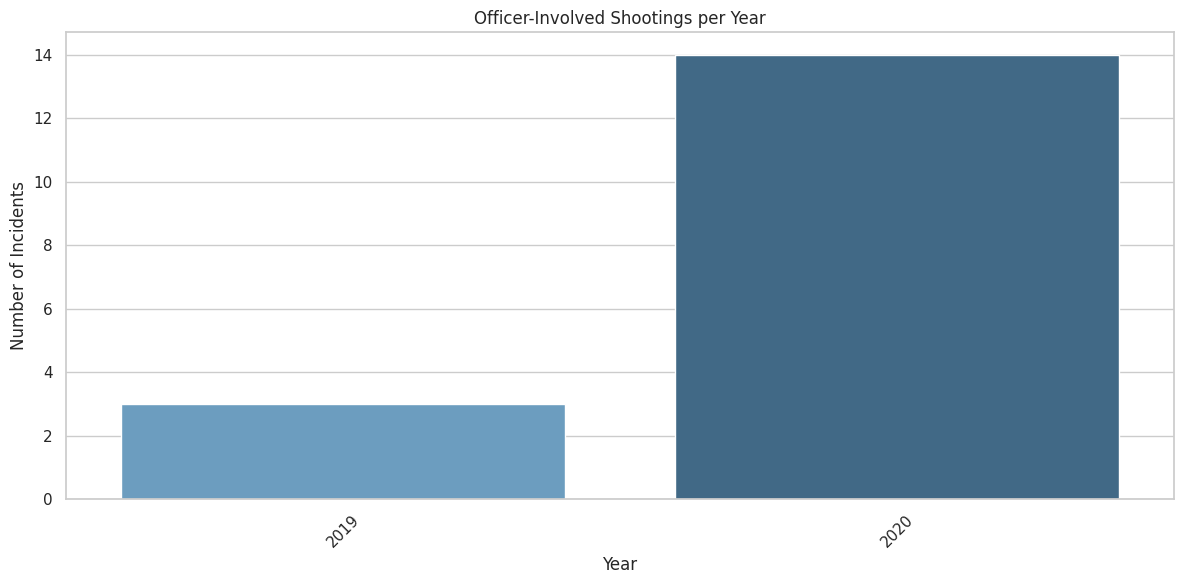

In [ ]:
# by time distribution
usable_df['DATE'] = pd.to_datetime(usable_df['DATE'], errors='coerce')
usable_df['YEAR'] = pd.to_numeric(usable_df['YEAR'], errors='coerce')


plt.figure()
sns.countplot(data=usable_df, x='YEAR', palette='Blues_d')
plt.title("Officer-Involved Shootings per Year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-121-4769ee161e85>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, x='DAY_OF_WEEK',


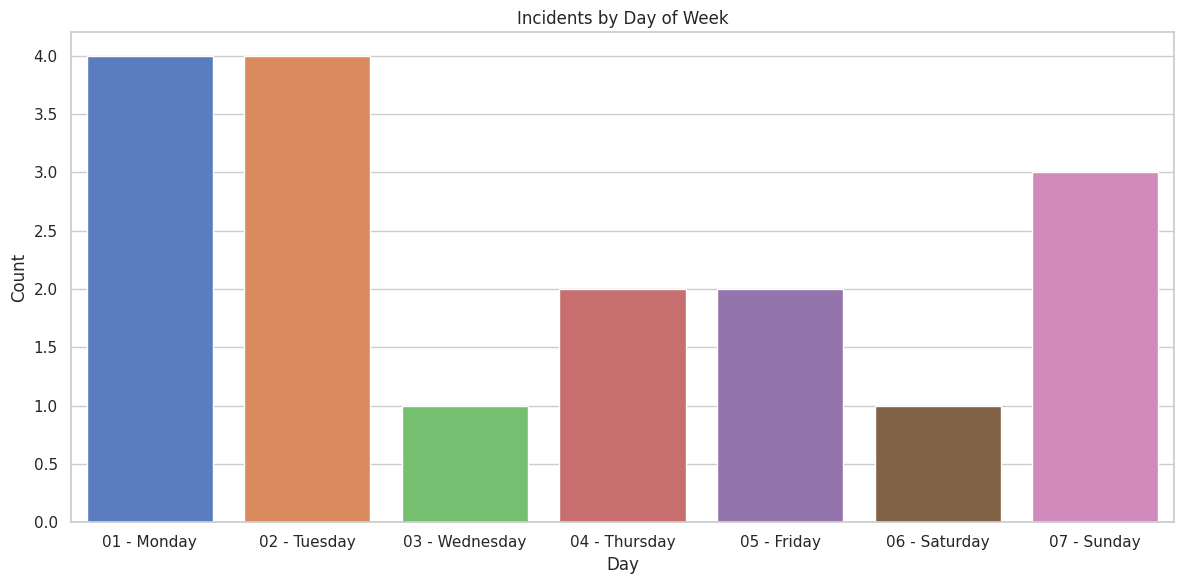

In [ ]:
# by day of th eweek
plt.figure()
sns.countplot(data=usable_df, x='DAY_OF_WEEK',
              order=['01 - Monday', '02 - Tuesday', '03 - Wednesday', '04 - Thursday', '05 - Friday', '06 - Saturday', '07 - Sunday'],
              palette='muted')
plt.title("Incidents by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<ipython-input-122-4fee1c5d2084>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, y='PRECINCT',


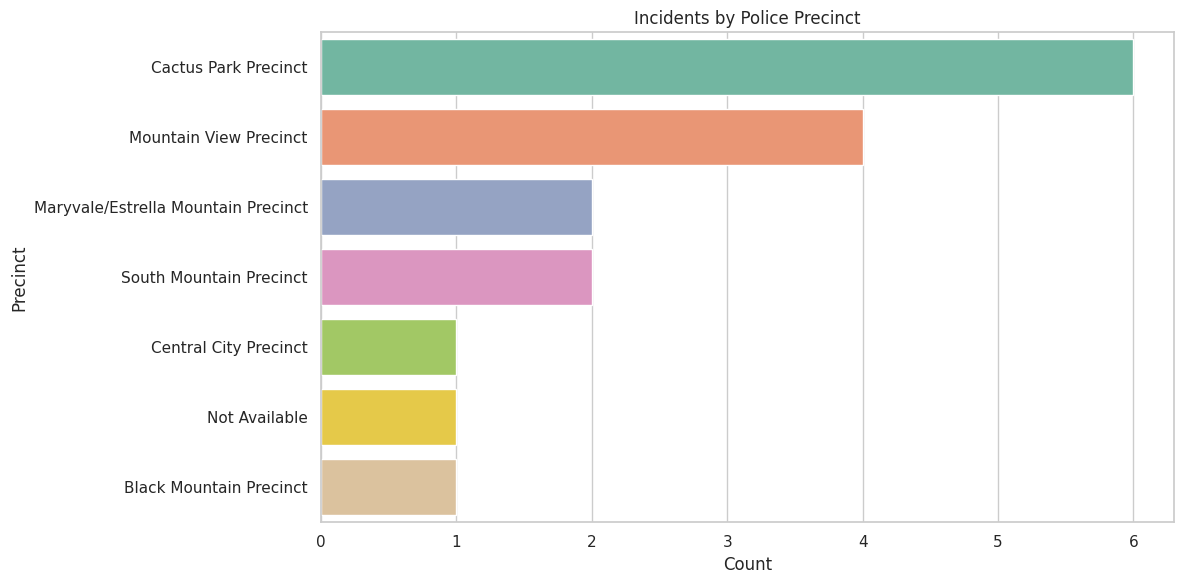

In [ ]:
# by precinct location
plt.figure()
sns.countplot(data=usable_df, y='PRECINCT',
              order=usable_df['PRECINCT'].value_counts().index,
              palette='Set2')
plt.title("Incidents by Police Precinct")
plt.xlabel("Count")
plt.ylabel("Precinct")
plt.tight_layout()
plt.show()

<ipython-input-123-0f20518e001d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, x='SP_AGE_GROUP',


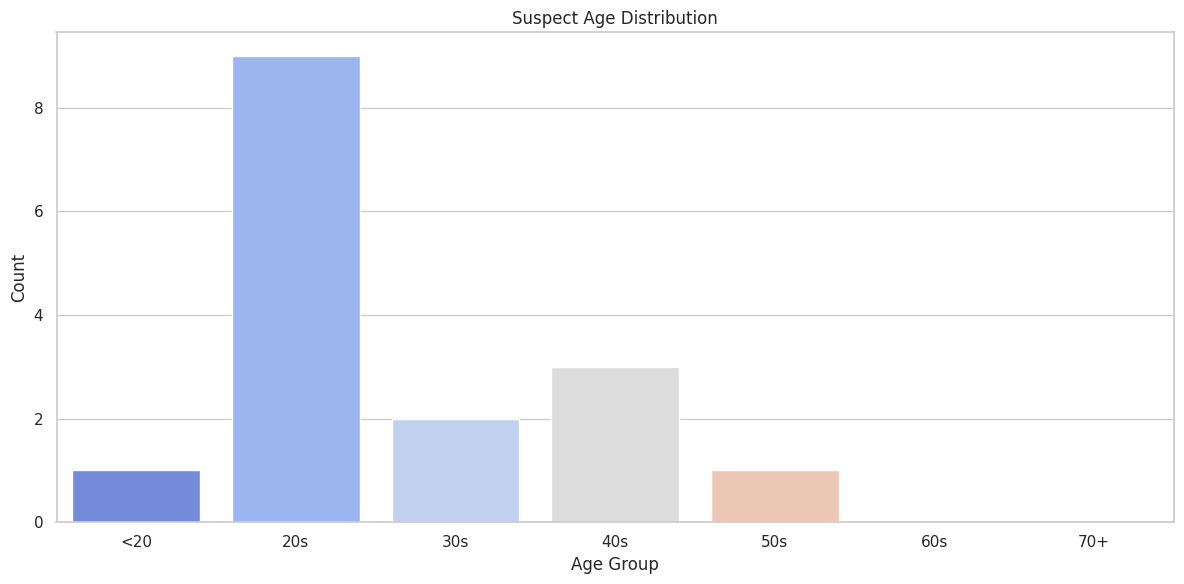

<ipython-input-123-0f20518e001d>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, x='SP_GENDER', palette='pastel')


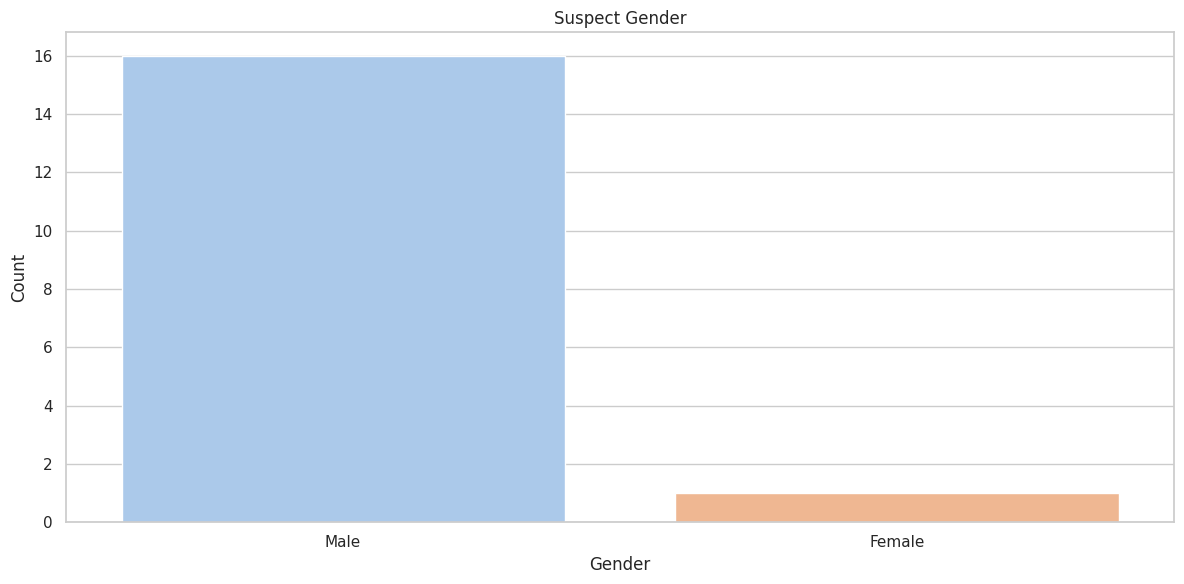

<ipython-input-123-0f20518e001d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, y='SP_RACE',


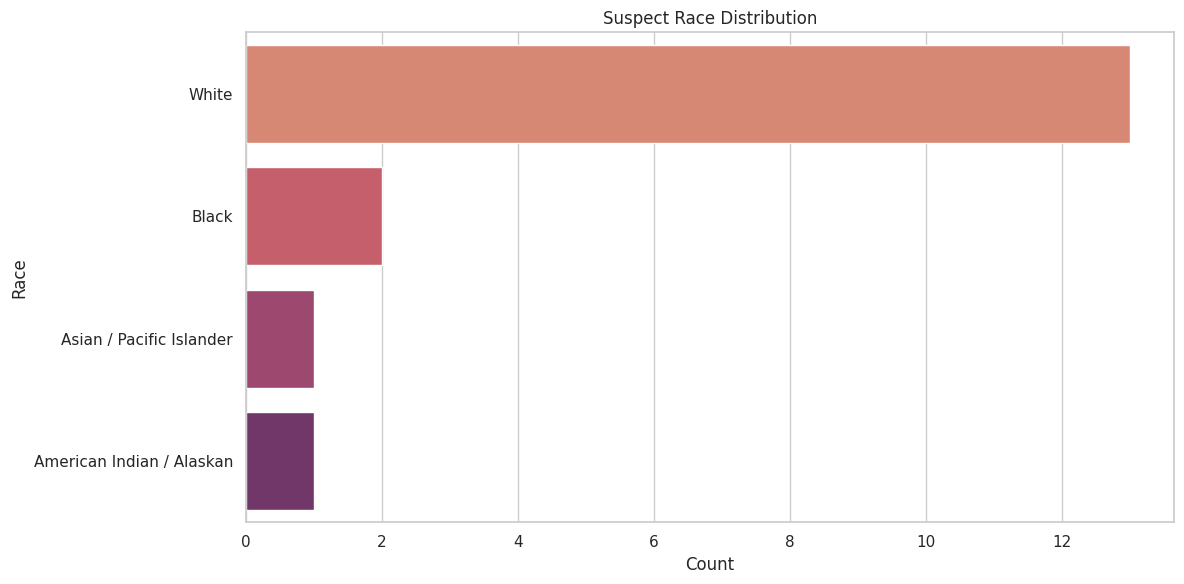

In [ ]:
# suspect demographics

# age group
plt.figure()
sns.countplot(data=usable_df, x='SP_AGE_GROUP',
              order=['<20', '20s', '30s', '40s', '50s', '60s', '70+'],
              palette='coolwarm')
plt.title("Suspect Age Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# gender
plt.figure()
sns.countplot(data=usable_df, x='SP_GENDER', palette='pastel')
plt.title("Suspect Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# race
plt.figure()
sns.countplot(data=usable_df, y='SP_RACE',
              order=usable_df['SP_RACE'].value_counts().index,
              palette='flare')
plt.title("Suspect Race Distribution")
plt.xlabel("Count")
plt.ylabel("Race")
plt.tight_layout()
plt.show()


<ipython-input-124-f9dbebe082c2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, y='PO_RACE',


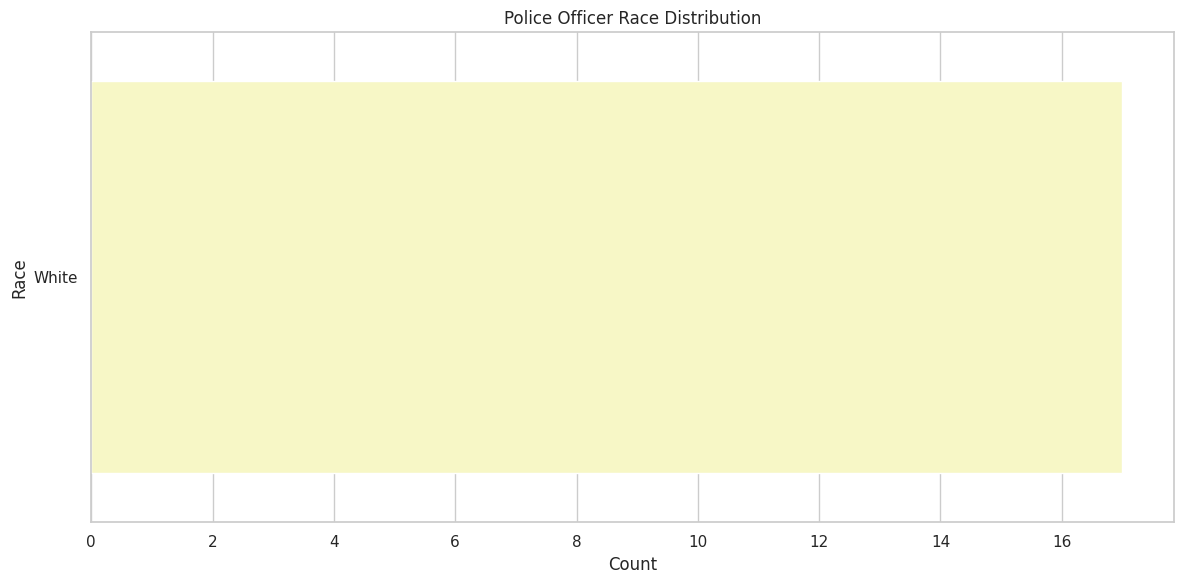

<ipython-input-124-f9dbebe082c2>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, y='PO_ETHNICITY',


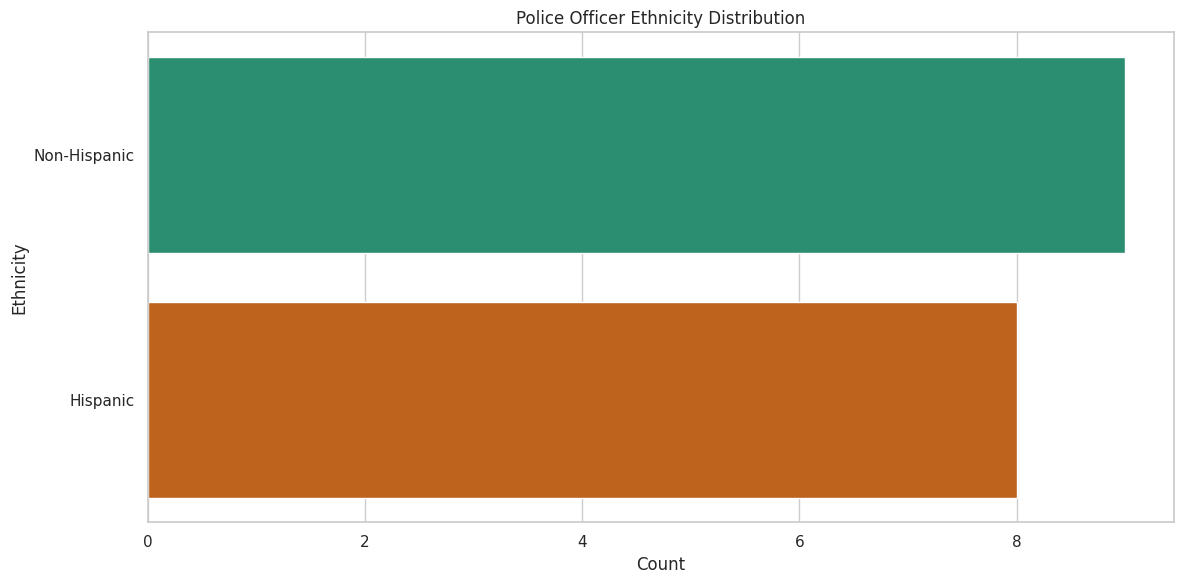

In [ ]:
# officer demographics

# race
plt.figure()
sns.countplot(data=usable_df, y='PO_RACE',
              order=usable_df['PO_RACE'].value_counts().index,
              palette='Spectral')
plt.title("Police Officer Race Distribution")
plt.xlabel("Count")
plt.ylabel("Race")
plt.tight_layout()
plt.show()

# ethnicity
plt.figure()
sns.countplot(data=usable_df, y='PO_ETHNICITY',
              order=usable_df['PO_ETHNICITY'].value_counts().index,
              palette='Dark2')
plt.title("Police Officer Ethnicity Distribution")
plt.xlabel("Count")
plt.ylabel("Ethnicity")
plt.tight_layout()
plt.show()


<ipython-input-125-248bb27bca36>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, x='SP_INJURY_LEVEL', palette='Set1')


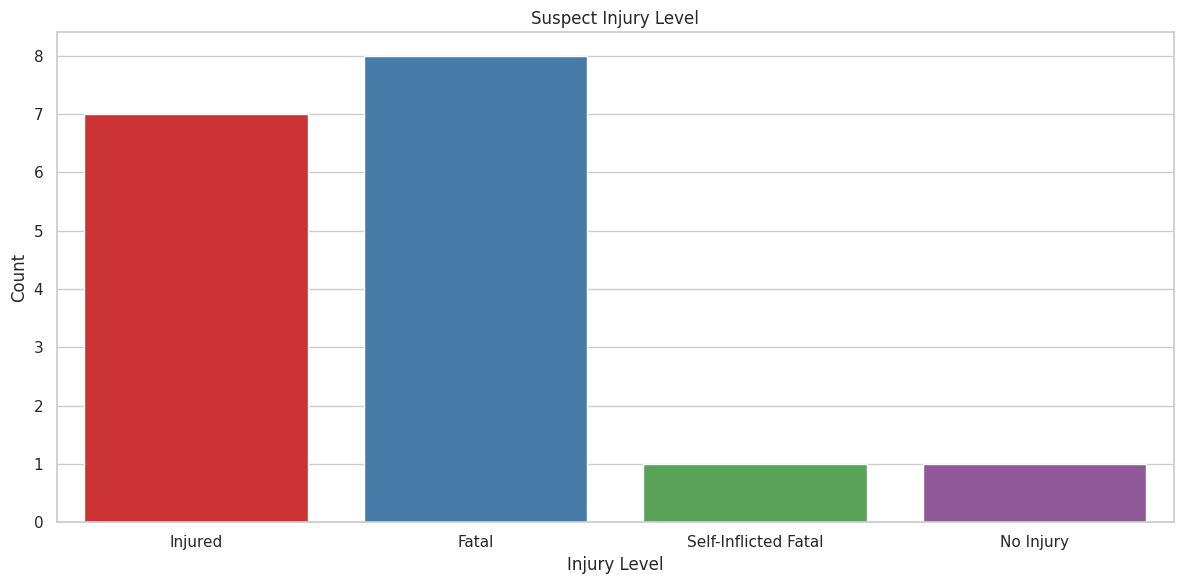

<ipython-input-125-248bb27bca36>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=usable_df, x='FATALITY_FLG', palette='Reds')


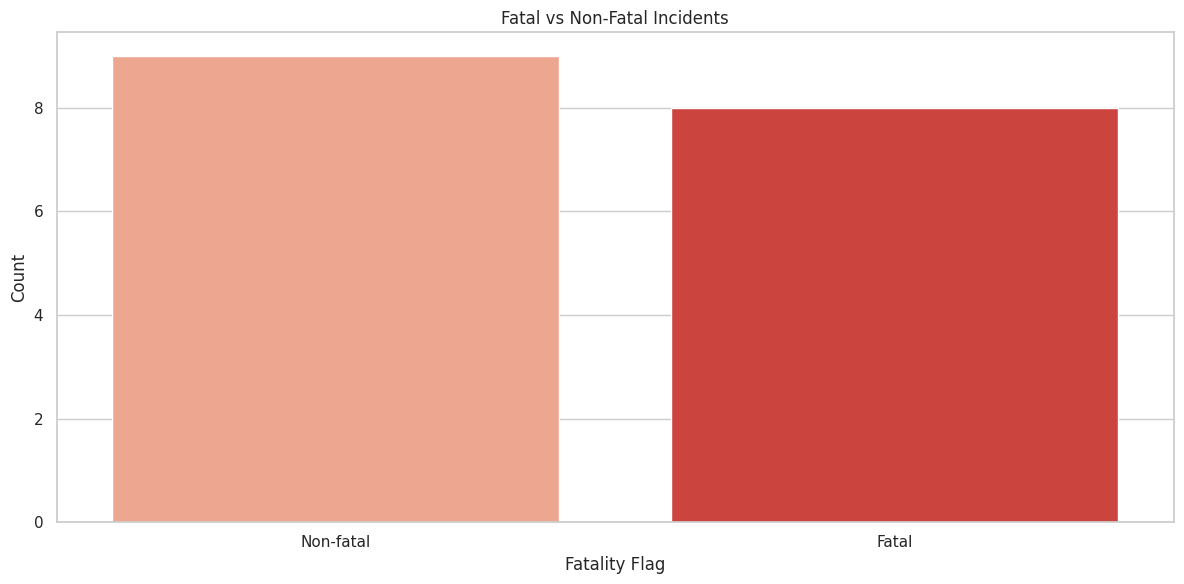

In [ ]:
# what happens

# injury level
plt.figure()
sns.countplot(data=usable_df, x='SP_INJURY_LEVEL', palette='Set1')
plt.title("Suspect Injury Level")
plt.xlabel("Injury Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# fatality
plt.figure()
sns.countplot(data=usable_df, x='FATALITY_FLG', palette='Reds')
plt.title("Fatal vs Non-Fatal Incidents")
plt.xlabel("Fatality Flag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



### **Building the Model**

In [ ]:
usable_df.columns

Index(['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR',
       'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON',
       'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY',
       'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY',
       'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y',
       'CRITICAL INCIDENT BRIEFING VIDEO_x', 'MEDIA RELEASE', 'None',
       'has_video', 'has_transcript', 'CRITICAL INCIDENT BRIEFING VIDEO_y',
       'SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END',
       'Reason for Removal', 'comments', 'USABILITY'],
      dtype='object')

In [ ]:
usable_df['SP_WEAPON'].unique()

array(['Firearm', 'Bladed Object', 'Vehicle', 'Simulated Firearm'],
      dtype=object)

In [ ]:
master_df['DATE']

,DATE
0,2019-01-11
1,2019-01-30
2,2019-03-09
3,2019-03-13
4,2019-03-28
...,...
119,2024-05-07
120,2024-05-16
121,2024-05-28
122,2024-02-02


# **Neural Net for Predicting Suspect Fatality Based on DAYLIGHT, SP_GENDER, SP_RACE, SP_WEAPON, SP_AGE_AT_INC, PO_RACE, HOUR, and SP_BEHV**

### **Model Summary**

The model is an MLP neural network that predicts the binary FATALITY_FLG (1 for 'Fatal', 0 for non-fatal) in officer-involved shootings based on a curated feature set from the Phoenix Police Department dataset: DAYLIGHT, SP_GENDER, SP_RACE, SP_WEAPON, SP_AGE_AT_INC, PO_RACE, HOUR, and SP_BEHV. It preprocesses categorical features by one-hot encoding after imputing missing values with 'Unknown', and numerical features (e.g., SP_AGE_AT_INC, HOUR) by imputing with the mean, then normalizing. The network contains two hidden layers (64 and 32 neurons with ReLU activation, dropout rates 0.3 and 0.2) and a sigmoid output layer, trained with binary cross-entropy loss and the Adam optimizer for 25 epochs with batch size 4. The model is trained on a small dataset (~17 samples) with an 80/20 train/test split, using gradient clipping to prevent numerical instability. This setup attempts to forecast elements for deadly results without making use of leakage-prone attributes like SP_INJURY_LEVEL.

### **Results**

The model trains with no NaN loss, decreasing training loss (from 0.8931 to 0.2567) and high training accuracy (up to 1.0000), indicating that it accommodates the training data (13 samples) well, likely due to the small dataset size. But validation accuracy is consistently low (0.2500 after initial fluctuations) and validation loss increases (0.6743 to 0.8827), suggesting overfitting and inability to generalize to the test set 4 samples). Classification report is overall accuracy 0.25, with the model correctly predicting the single non-fatal case (precision 0.25, recall 1.00, F1 0.40) but failing to predict the three fatal cases (precision, recall, F1 all 0.00). This poor performance is likely due to the limited test set and potential class imbalance, with the model being biased toward non-fatal predictions. The results suggest the need for a larger dataset or cross-validation for improving reliability and generalizability.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# set X
selected_features = [
    'DAYLIGHT', 'SP_GENDER', 'SP_RACE', 'SP_WEAPON', 'SP_AGE_AT_INC',
    'PO_RACE', 'HOUR', 'SP_BEHV'
]

# set y
target_column = 'FATALITY_FLG'


fatality_model_df = usable_df[selected_features + [target_column]].copy()

cat_cols = ['DAYLIGHT', 'SP_GENDER', 'SP_RACE', 'SP_WEAPON', 'PO_RACE', 'SP_BEHV']
for col in cat_cols:
    fatality_model_df[col] = fatality_model_df[col].astype(str).fillna('Unknown')

num_cols = ['SP_AGE_AT_INC', 'HOUR']
for col in num_cols:
    fatality_model_df[col] = fatality_model_df[col].fillna(fatality_model_df[col].mean())

fatality_model_df[target_column] = fatality_model_df[target_column].astype(str).fillna('Unknown')

fatality_model_df['target'] = fatality_model_df[target_column].apply(lambda x: 1 if 'Fatal' in x else 0)

# one-hot encode categorical columns
df_encoded = pd.get_dummies(fatality_model_df, columns=cat_cols, drop_first=True)



# split features after encoding
X = df_encoded.drop(columns=['target', target_column])
y = df_encoded['target']

# scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# build and train model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=4, verbose=1)

# accuracy
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.3897 - loss: 0.6988 - val_accuracy: 0.7500 - val_loss: 0.6646
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2455 - loss: 0.9079 - val_accuracy: 0.7500 - val_loss: 0.6728
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6878 - loss: 0.7092 - val_accuracy: 0.5000 - val_loss: 0.6813
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4147 - loss: 0.7211 - val_accuracy: 0.5000 - val_loss: 0.6900
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5821 - loss: 0.7556 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5154 - loss: 0.6242 - val_accuracy: 0.2500 - val_loss: 0.7091
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8327 - loss: 0.5713 - val_accuracy: 0.2500 - val_loss: 0.7174
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5628 - loss: 0.6593 - val_accuracy: 0.2500 - val_loss: 0.7248

In [ ]:
usable_df.columns

Index(['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR',
       'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON',
       'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY',
       'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY',
       'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y',
       'CRITICAL INCIDENT BRIEFING VIDEO_x', 'MEDIA RELEASE', 'None',
       'has_video', 'has_transcript', 'CRITICAL INCIDENT BRIEFING VIDEO_y',
       'SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END',
       'Reason for Removal', 'comments', 'USABILITY'],
      dtype='object')

### **Model**
The suggested model is a natural language processing (NLP) pipeline which forecasts the occurrence of a fatality in police incidents solely from the text material of body cam video transcripts. It begins by merging a cleaned dataset of available police incidents along with their respective transcript files, and preprocessed transcripts by cleaning them—excluding timestamps, punctuation, and standardizing whitespace. With the pre-cleaned transcripts, it converts the text to numerical features through TF-IDF (Term Frequency–Inverse Document Frequency) vectorization, which captures the importance of words in each document. They are fed into a logistic regression classifier that has been trained to distinguish between fatal and non-fatal incidents based on the textual content. The model uses an 80/20 train-test split to evaluate its generalization performance.

### **Results**
The results, presented via a classification report, illustrate how well the model works in predicting death based on transcript data. Significant measures such as precision, recall, and F1-score all reflect the balance between correctly establishing fatal cases and not providing false alarms. A strong F1-score would signify that linguistic practice in officer-suspect talk or event reports tends to conform to whether a fatality occurred or not. If the scores are low or medium, it might indicate that transcripts alone are insufficient to predict with high accuracy, or that higher-grained language processing (e.g., knowing context or temporal structure) is necessary. The model establishes a baseline for testing whether language used in police encounters in real time may encode predictors of use-of-force outcomes.










In [ ]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print("Columns in usable_df:", usable_df.columns.tolist())
if 'target' not in usable_df.columns:
    print("Creating target from FATALITY_FLG")
    usable_df['target'] = usable_df['FATALITY_FLG'].astype(str).apply(lambda x: 1 if 'Fatal' in x else 0)

# load transcripts
transcript_records = []
for filename in os.listdir(transcript_dir):
    if filename.endswith('_transcript.txt'):
        inc_rpt = filename.replace('_transcript.txt', '')
        with open(os.path.join(transcript_dir, filename), 'r', encoding='utf-8') as f:
            text = f.read()
            transcript_records.append({'INC_RPT': inc_rpt, 'transcript': text})

df_transcripts = pd.DataFrame(transcript_records)

print("Shape of usable_df:", usable_df.shape)
print("Shape of df_transcripts:", df_transcripts.shape)
print("Sample INC_RPT in usable_df:", usable_df['INC_RPT'].head().tolist())
print("Sample INC_RPT in df_transcripts:", df_transcripts['INC_RPT'].head().tolist())

# merge with usable_df
nlp_model_df = pd.merge(usable_df[['INC_RPT', 'target']].reset_index(drop=True),
                        df_transcripts,
                        on='INC_RPT',
                        how='left')

print("Shape of nlp_model_df:", nlp_model_df.shape)
print("Columns in nlp_model_df:", nlp_model_df.columns.tolist())
print("NaNs in transcript:", nlp_model_df['transcript'].isna().sum())
print("NaNs in target:", nlp_model_df['target'].isna().sum())

# drop nan
nlp_model_df = nlp_model_df.dropna(subset=['transcript'])

nlp_model_df = nlp_model_df[['transcript', 'target']]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+(\.\d+)?s?:", "", text)  # remove timestamp markers like "12.00s:"
    text = re.sub(r"[^a-zA-Z\s]", "", text)     # remove punctuation
    text = re.sub(r"\s+", " ", text)            # remove extra spaces
    return text.strip()

nlp_model_df['clean_text'] = nlp_model_df['transcript'].apply(clean_text)

# TF-IDF + Logistic Regression pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# train test split
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    nlp_model_df['clean_text'], nlp_model_df['target'], test_size=0.2, random_state=42)

# predictions
text_clf.fit(X_train_text, y_train_text)

# accuracy
y_pred_text = text_clf.predict(X_test_text)
print("Transcript Model Classification Report:")
print(classification_report(y_pred_text, y_test_text))

Columns in usable_df: ['DATE', 'TIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'YEAR', 'INC_RPT', 'PRECINCT', 'COUNCIL_DIST', 'LOCATION_x', 'SP_WEAPON', 'SP_INJURY_LEVEL', 'FATALITY_FLG', 'SP_GENDER', 'SP_ETHNICITY', 'SP_RACE', 'SP_AGE_AT_INC', 'SP_AGE_GROUP', 'PO_RACE', 'PO_ETHNICITY', 'REFERENCE_ID', 'SP_NUM', 'SERIES', 'ï»¿_id', 'LOCATION_y', 'CRITICAL INCIDENT BRIEFING VIDEO_x', 'MEDIA RELEASE', 'None', 'has_video', 'has_transcript', 'CRITICAL INCIDENT BRIEFING VIDEO_y', 'SP_BEHV', 'PO_BEHV', 'DAYLIGHT', 'BODY_CAM_START', 'BODY_CAM_END', 'Reason for Removal', 'comments', 'USABILITY', 'target']
Shape of usable_df: (17, 41)
Shape of df_transcripts: (37, 2)
Sample INC_RPT in usable_df: ['2019-1483520', '2019-1565190', '2019-1967281', '2020-0034260', '2020-0443959']
Sample INC_RPT in df_transcripts: ['2020-2085772', '2021-0045284', '2021-0373649', '2021-0521605', '2021-0713845']
Shape of nlp_model_df: (17, 3)
Columns in nlp_model_df: ['INC_RPT', 'target', 'transcript']
NaNs in trans

<ipython-input-135-dc6b8cda13f6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette="viridis")


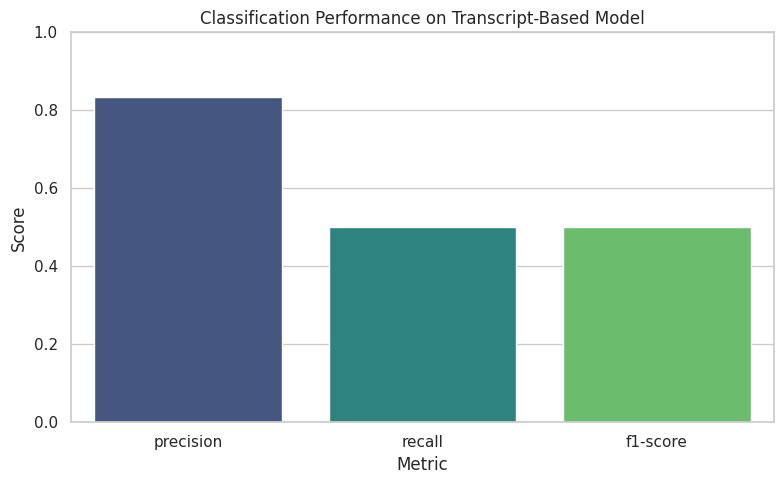

In [ ]:
# visualize accuracy

report = classification_report(y_test_text, y_pred_text, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
scores = [report['weighted avg'][metric] for metric in metrics]


sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=scores, palette="viridis")
plt.ylim(0, 1)
plt.title("Classification Performance on Transcript-Based Model")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()


Precision score is the true positive/actual results, so the model predicted the incident was fatal and it was actually fatal.
The precision = 0.83, then 83% of predicted fatal cases were actually fatal.

Recall is the true positive/predicted results, so the model correctly identified a fatal incident out of all actual incidents. If recall = 0.50, it means your model caught 50% of all true fatal incidents.

F1 score is the harmonic mean of precision and recall, the higher the better.

## **PREDICTING SUSPECT AND POLICE BEHAVIOR FROM BODY CAM FOOTAGE**

###### *USES PRETRAINED MODEL


### **Model**

The deep learning pipeline of the following Python code predicts suspect behavior (SP_BEHV) and police officer behavior (PO_BEHV) from body camera video based on a pre-trained ResNet18 model. The code loads a dataset (usable_df) with 18 samples, where each sample pairs an INC_RPT identifier with a.jpg image in a subfolder of body_cam_vids and corresponding SP_BEHV and PO_BEHV labels. The BodyCamDataset class handles loading images from subdirectories, applying transformations (resize to 224x224), and getting data ready for training. The dataset is divided into 80-20 (14 training, 4 validation samples), and the model is trained for 10 epochs with mean squared error (MSE) loss and Adam optimizer (learning rate 1e-4). Training and validation losses are printed by epoch using PyTorch for GPU/CPU support.

### **Results**
The training output indicates a consistent decrease in training loss from 20.7620 to 11.7102 and validation loss from 24.5941 to 17.2098 across 10 epochs, indicating the learning of the model in predicting SP_BEHV and PO_BEHV. The steep early losses indicate early predictions of the model being far from target values, which is most likely due to the compact dataset size (18 samples) and complexity of the behavior prediction task. The validation loss remains greater than the training loss, with some overfitting, but the margin shrinks by epoch 10. These outcomes depict the ability of the model to learn meaningful features from video frames but high losses and sparse data limit predictive accuracy. Enhancement may involve acquiring more data or combining temporal video knowledge to enhance performance.

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms


class BodyCamDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # import data
        usable_df = pd.read_csv(csv_file)
        print(f"Total rows in usable_df: {len(usable_df)}")

        # filter rows to make sure there is a folder with respective INC_RPT number
        valid_rows = 0
        for _, row in usable_df.iterrows():
            if pd.isna(row['INC_RPT']):
                print(f"Skipping row with missing INC_RPT: {row}")
                continue

            # use subfolder for directory
            subfolder = os.path.join(self.root_dir, str(row['INC_RPT']))

            # check if subfolder exists
            if not os.path.isdir(subfolder):
                print(f"Subfolder not found: {subfolder}")
                continue

            # find all .jpg images in the subfolder
            img_files = [f for f in os.listdir(subfolder) if f.lower().endswith('.jpg')]
            if not img_files:
                print(f"No .jpg images found in subfolder: {subfolder}")
                continue

            # USES FIRST VIDEO in folder
            img_name = img_files[0]
            img_path = os.path.join(subfolder, img_name)

            # check if image is there
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                continue

            self.data.append({
                'image': img_path,
                'sp_behv': row['SP_BEHV'] if not pd.isna(row['SP_BEHV']) else -1,
                'po_behv': row['PO_BEHV'] if not pd.isna(row['PO_BEHV']) else -1
            })
            valid_rows += 1

        print(f"Number of usable rows in CSV: {valid_rows}")
        print(f"Number of images loaded: {len(self.data)}")

        if len(self.data) == 0:
            print("Warning: No valid data loaded. Check CSV content and image paths.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        image = Image.open(record['image']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # convert to tensors
        sp_behv = torch.tensor(record['sp_behv'], dtype=torch.float32)
        po_behv = torch.tensor(record['po_behv'], dtype=torch.float32)

        return image, sp_behv, po_behv

class VideoOnlyBehaviorModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        # only use the features selected
        self.cnn.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.out_sp = nn.Linear(64, 1)
        self.out_po = nn.Linear(64, 1)

    def forward(self, image):
        img_feat = self.cnn(image)
        x = self.fc(img_feat)
        sp = self.out_sp(x).squeeze(1)
        po = self.out_po(x).squeeze(1)
        return sp, po

# use transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# import data
dataset = BodyCamDataset(
    csv_file='/content/drive/MyDrive/DAT494/Final Project/manual_behavior_labels.csv',
    root_dir='/content/drive/MyDrive/DAT494/Final Project/body_cam_vids',
    transform=transform
)

# train test split 80/20
indices = list(range(len(dataset)))
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)
train_size = int(0.8 * len(dataset))
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# use dataloaders for simplification
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler, num_workers=2, pin_memory=True)

# use adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VideoOnlyBehaviorModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"Training on {device}")
print(f"Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}")

# training loop with 10 epochs
for epoch in range(10):
    model.train()
    train_loss = 0
    for images, sp_labels, po_labels in train_loader:
        images = images.to(device, non_blocking=True)
        sp_labels = sp_labels.to(device, non_blocking=True)
        po_labels = po_labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        sp_preds, po_preds = model(images)
        loss_sp = criterion(sp_preds, sp_labels)
        loss_po = criterion(po_preds, po_labels)
        loss = loss_sp + loss_po

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validate model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, sp_labels, po_labels in val_loader:
            images = images.to(device, non_blocking=True)
            sp_labels = sp_labels.to(device, non_blocking=True)
            po_labels = po_labels.to(device, non_blocking=True)
            sp_preds, po_preds = model(images)
            loss_sp = criterion(sp_preds, sp_labels)
            loss_po = criterion(po_preds, po_labels)
            val_loss += (loss_sp + loss_po).item()

    print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}")

Total rows in usable_df: 124
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0055839
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0171132
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0406293
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0424535
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0516476
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0722449
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0785563
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0849179
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-0892262
Subfolder not found: /content/drive/MyDrive/DAT494/Final Project/body_cam_vids/2019-1499220
Subfolder not found: /content/drive/MyDrive/DAT494/